# Analyse du facteur de charge éolien à Toulouse entre 1980 et 2022

### Chargement des packages et choix des options

In [26]:
#importation des packages

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import random
import pyarrow
import statsmodels.api as sm

In [2]:
#Choix des options

#Lien pour les données
#data_path=""
#data_path="Données/"
data_path="Données/"

## Mise en forme des données

On a des téléchargé les données de facteur de charge à Toulouse pour un certain modèle d'éolienne (voir Info_données dans le dossier data/Toulouse/Wind_power_default) sous forme de 43 fichiers CSV (1 par an). L'idée est de combiner toute es données pour obtenir un fichier csv avec les données horaires et un fichier avec les données journalières pour la suite de l'étude.
On fait le choix de créer se programme en dehors dans le fichier 'utility_tools' pour pouvoir le réutiliser par la suite.

In [3]:
from utility_tools import regroupement_data

data_hour_wind,data_day_wind=regroupement_data(data_path+'Data_Toulouse/Wind_power_default/',1980,2022)

print(data_hour_wind.head(),data_hour_wind.tail(),data_day_wind.head(),data_day_wind.tail())
#print(data_day_wind.dtypes)

Toutes les données sont différentes
                 time        local_time  electricity  wind_speed
0 1980-01-01 00:00:00  1980-01-01 01:00        0.132       5.062
1 1980-01-01 01:00:00  1980-01-01 02:00        0.108       4.756
2 1980-01-01 02:00:00  1980-01-01 03:00        0.107       4.753
3 1980-01-01 03:00:00  1980-01-01 04:00        0.086       4.448
4 1980-01-01 04:00:00  1980-01-01 05:00        0.085       4.439                     time        local_time  electricity  wind_speed
8755 2022-12-31 19:00:00  2022-12-31 20:00        0.429       7.650
8756 2022-12-31 20:00:00  2022-12-31 21:00        0.422       7.603
8757 2022-12-31 21:00:00  2022-12-31 22:00        0.420       7.593
8758 2022-12-31 22:00:00  2022-12-31 23:00        0.426       7.632
8759 2022-12-31 23:00:00  2023-01-01 00:00        0.423       7.613             electricity  wind_speed
time                               
1980-01-01     0.274292    6.263542
1980-01-02     0.334875    6.864042
1980-01-03     0.02370

On va maintenant afficher les données journalières et horaires

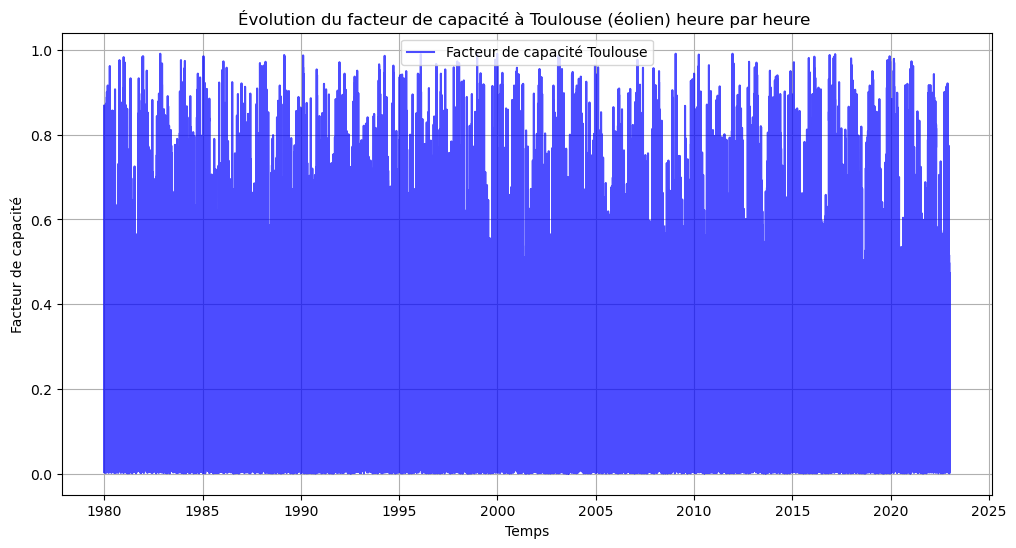

In [4]:
# Création du graphique de série temporelle pour la capacité
plt.figure(figsize=(12, 6))
plt.plot(data_hour_wind['time'], data_hour_wind['electricity'], label='Facteur de capacité Toulouse', color='blue', alpha=0.7)
plt.title('Évolution du facteur de capacité à Toulouse (éolien) heure par heure ')
plt.xlabel('Temps')
plt.ylabel('Facteur de capacité')
plt.legend()
plt.grid(True)
plt.show()


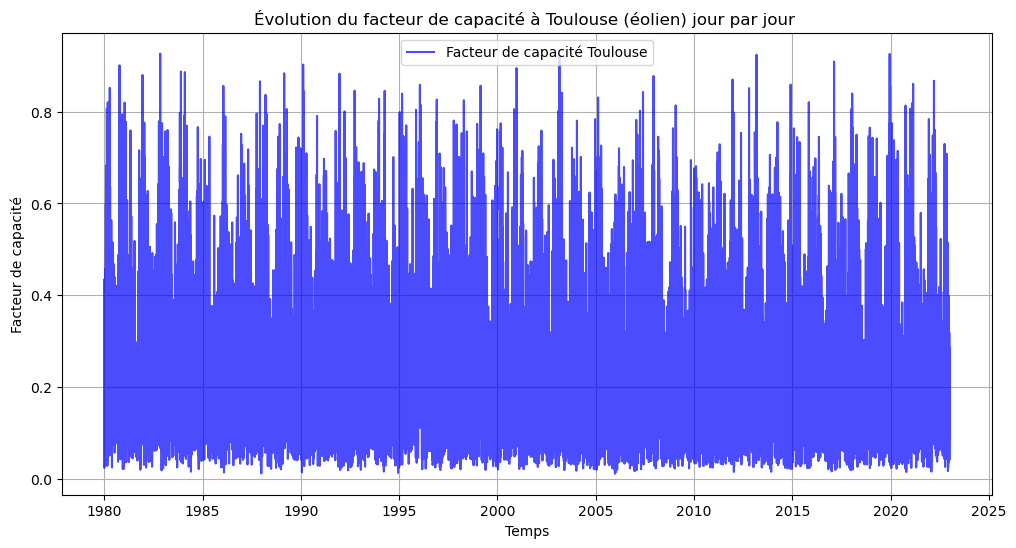

In [5]:
# Création du graphique de série temporelle pour la capacité
plt.figure(figsize=(12, 6))
plt.plot(data_day_wind.index, data_day_wind['electricity'], label='Facteur de capacité Toulouse', color='blue', alpha=0.7)
plt.title('Évolution du facteur de capacité à Toulouse (éolien) jour par jour ')
plt.xlabel('Temps')
plt.ylabel('Facteur de capacité')
plt.legend()
plt.grid(True)
plt.show()

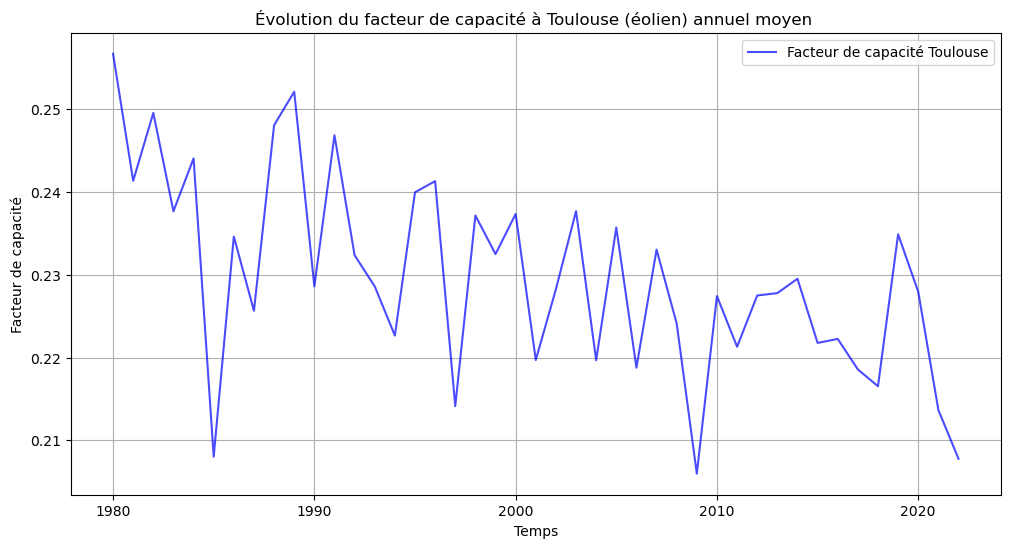

In [6]:
# On commence par regrouper les données par année

data_year_wind = data_hour_wind.groupby(data_hour_wind['time'].dt.year).agg({'electricity': 'mean', 'wind_speed': 'mean'})

# Création du graphique de série temporelle pour la capacité nationale
plt.figure(figsize=(12, 6))
plt.plot(data_year_wind.index, data_year_wind['electricity'], label='Facteur de capacité Toulouse', color='blue', alpha=0.7)
plt.title('Évolution du facteur de capacité à Toulouse (éolien) annuel moyen ')
plt.xlabel('Temps')
plt.ylabel('Facteur de capacité')
plt.legend()
plt.grid(True)
plt.show()

## Etude de tendance et saisonnalité

### Etude de la tendance

On va maintenant étudier la tendance de nos données.

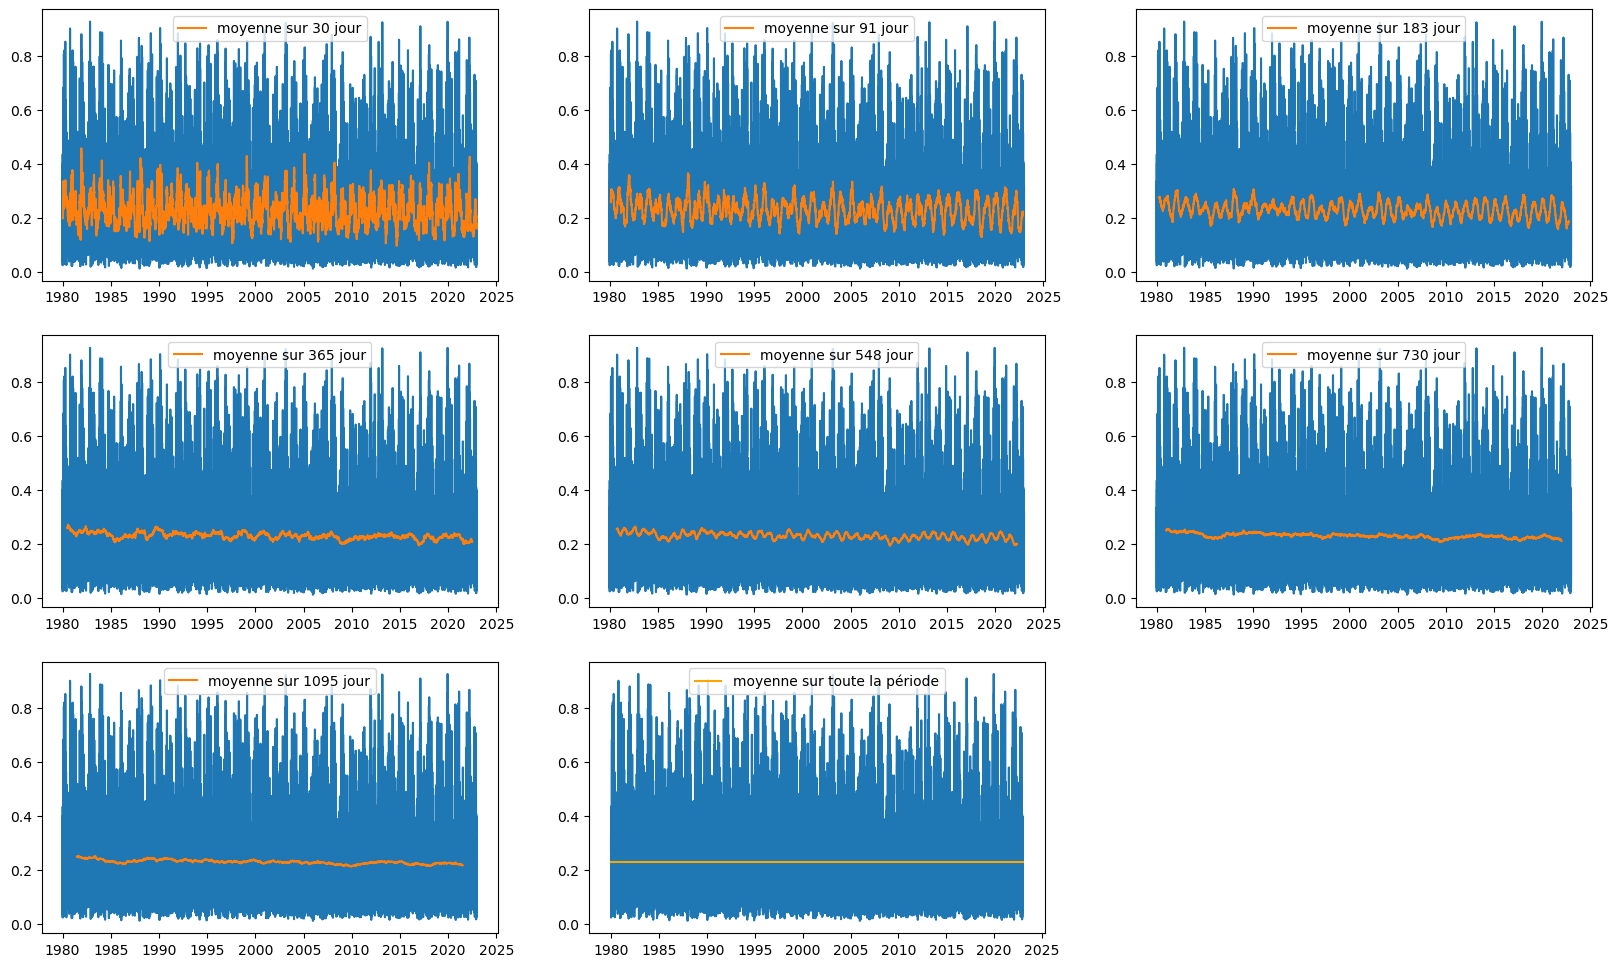

In [7]:
win = [30, 91, 183, 365, 548, 730, 1095] # fenêtre d'observation (en nombre de semaines)
fig = plt.figure(figsize=(20,12))

for i in range(len(win)):
    ax = fig.add_subplot(3, 3, i+1)
    ax.plot(data_day_wind['electricity'])
    ax.plot(data_day_wind['electricity'].rolling(win[i], center=True).mean(), label=f"moyenne sur {win[i]} jour")
    ax.legend()
    
ax = fig.add_subplot(3, 3, 8)
ax.plot(data_day_wind['electricity'])
ax.hlines(data_day_wind['electricity'].mean(), xmin=3600,xmax=19400,label=f"moyenne sur toute la période",color='orange')
ax.legend()

On observe la tendance sur 1 mois, 3 mois, 6 mois, 1 an, 1 an et demi, 2 ans et 3 ans. On observe que quand la durée de la fenêtre augmente, la tendance approche de plus en plus d'une fonction constante : la tendance du facteur de charge éolien est donc plutôt constant. On observe également une tendance plus linéaire sur des multiples d'un an, ce qui confirme l'intuition qu'on a une saisonnalitée sur 1 an.
Cette analyse est cohérente avec nos intuitions : la tendance du vent n'évolue pas ou très peu au cours du temps.

### Etude de la saisonnalité

On va maintenant étudier la saisonnalité de nos données.

month  day
12     26     0.283665
       27     0.279244
       28     0.293127
       29     0.241680
       30     0.250356
       31     0.219791
1      1      0.247641
       2      0.296374
       3      0.242205
       4      0.246486
       5      0.234464
       6      0.252540
       7      0.231088
       8      0.233096
       9      0.207310
       10     0.231466
       11     0.242706
       12     0.228578
       13     0.263130
       14     0.271376
Name: electricity, dtype: float64
[0.23323865 0.23239784 0.23391071 0.23966611 0.24677865 0.25850069
 0.26240919 0.26298436 0.26489161 0.26139673 0.26214106 0.26235507
 0.26346595]


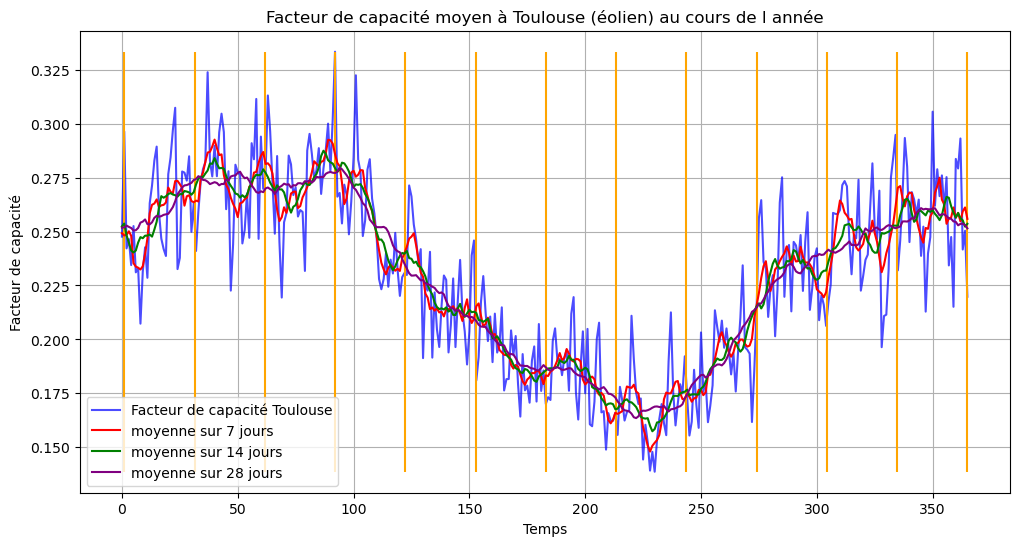

In [8]:
# On commence par regrouper les données par année
data_hour_copy=data_hour_wind.copy()
data_hour_copy['day']=data_hour_copy['time'].dt.day
data_hour_copy['month']=data_hour_copy['time'].dt.month

data_year_wind_tendance = data_hour_copy.groupby(['month', 'day']).agg({'electricity': 'mean', 'wind_speed': 'mean'})

#print(type(data_year_wind_tendance.index))



# Création du graphique de série temporelle pour la capacité nationale
plt.figure(figsize=(12, 6))
plt.plot(np.arange(366),data_year_wind_tendance['electricity'], label='Facteur de capacité Toulouse', color='blue', alpha=0.7)
plt.title('Facteur de capacité moyen à Toulouse (éolien) au cours de l année')
plt.xlabel('Temps')
plt.ylabel('Facteur de capacité')
plt.grid(True)

time_tick  = np.linspace(1, 365, 13)
plt.vlines(x = time_tick, ymin = data_year_wind_tendance['electricity'].min(), ymax = data_year_wind_tendance['electricity'].max(), colors = "orange")

print(pd.concat([data_year_wind_tendance['electricity'][360:],data_year_wind_tendance['electricity']])[:20])
print(data_year_wind_tendance['electricity'].rolling(7, center=True).mean().to_numpy()[:20][7:])

#On ajoute une "moyenne" en lissant
#On ajoute également des données avant et après pour avoir une moyenne lissée sur toute l'année

plt.plot(pd.concat([data_year_wind_tendance['electricity'][359:],data_year_wind_tendance['electricity'],data_year_wind_tendance['electricity'][:7]]).rolling(7, center=True).mean().to_numpy()[7:373], label=f"moyenne sur 7 jours", color = "red")
plt.plot(pd.concat([data_year_wind_tendance['electricity'][352:],data_year_wind_tendance['electricity'],data_year_wind_tendance['electricity'][:14]]).rolling(14, center=True).mean().to_numpy()[14:380], label=f"moyenne sur 14 jours", color = "green")
plt.plot(pd.concat([data_year_wind_tendance['electricity'][338:],data_year_wind_tendance['electricity'],data_year_wind_tendance['electricity'][:28]]).rolling(28, center=True).mean().to_numpy()[28:394], label=f"moyenne sur 28 jours", color = "purple")
plt.legend()

saison28=pd.concat([data_year_wind_tendance['electricity'][338:],data_year_wind_tendance['electricity'],data_year_wind_tendance['electricity'][:28]]).rolling(28, center=True).mean().to_numpy()[28:394]

plt.show()

Interprétation : à faire

### Etude avec la fonction "decompose"

On va maintenant étudier les données avec la fonction "decompose". Comment elle marche ?

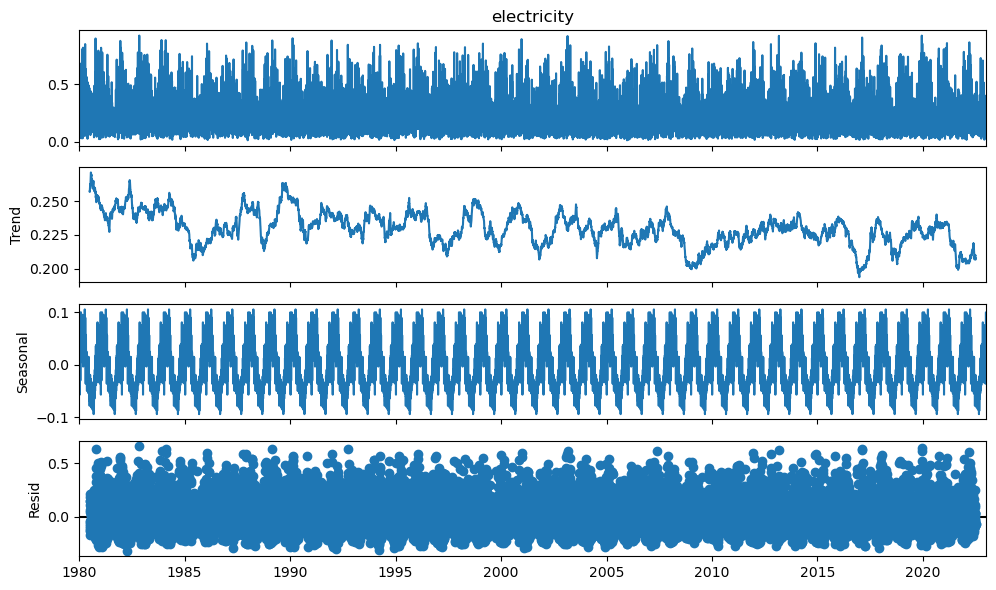

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

decomp = seasonal_decompose(data_day_wind['electricity'], model='additive',period=365)

fig = decomp.plot()
fig.set_size_inches((10, 6))
fig.tight_layout()
plt.show()

## Modèle ARMA

In [36]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



ImportError: cannot import name 'ARMA' from 'statsmodels.tsa.arima.model' (C:\Users\Manon Julia\anaconda3_2\Lib\site-packages\statsmodels\tsa\arima\model.py)

On va mettre en place un modèle ARMA a partir de la moyenne sur les 42 années de données observées. On commence oar étudier si cette série temporelle peut être modélisée par un modèle ARMA : 

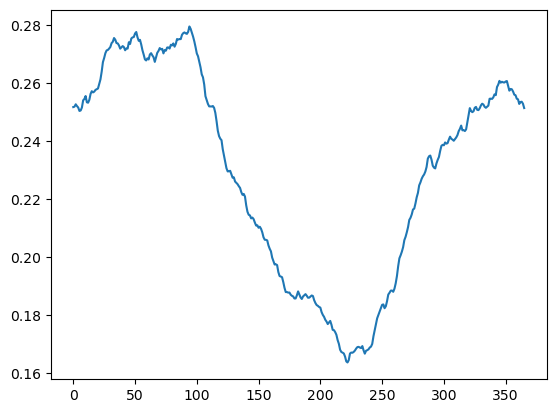

In [11]:
serie = (pd.concat([data_year_wind_tendance['electricity'][338:],data_year_wind_tendance['electricity'],data_year_wind_tendance['electricity'][:28]]).rolling(28, center=True).mean().to_numpy()[28:394])
plt.plot(serie)

### Etude de la faisabilité de la modélisation

In [30]:
_, p, _, _, _, _ = adfuller(serie)
print("La p-value est de: ", round(p, 3))

La p-value est de:  0.147


Ce bout de code permet de récupérer la p-value du test de Dickey-Fuller de la série. Ce score indique si la série peut être considérée comme stationnaire. En général, s’il est inférieur à 0.05, on la considère stationnaire. Ici, la p-valeur permet d'affirmer que la série est stationnaire. 

### Modélisation ARMA

On passe désormais à la modélisation de la série temporelle, qui va passer par la création d’un modèle ARMA dont il faudra ajuster les paramètres afin de correspondre le mieux possible à la série temporelle concernée.

Ici, les termes p et q correspondent respectivement au premier et au dernier chiffres de l’argument order de la fonction. La méthode fit ajoutée à la fin sert à entraîner le modèle pour qu’il détermine seul ses paramètres. 

La méthode summary permet de vérifier que notre modèle est bon, elle affiche :

In [13]:
arma = ARIMA(serie, order=(1,0,3)).fit()

arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  366
Model:                 ARIMA(1, 0, 3)   Log Likelihood                2001.948
Date:                Sat, 09 Mar 2024   AIC                          -3991.897
Time:                        18:52:38   BIC                          -3968.481
Sample:                             0   HQIC                         -3982.592
                                - 366                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2298      0.045      5.144      0.000       0.142       0.317
ar.L1          0.9985      0.003    383.147      0.000       0.993       1.004
ma.L1          0.4921      0.053      9.349      0.000       0.389       0.595
ma.L2          0.2939      0.059      4.946      0.000       0.177       0.410
ma.L3          0.1106      0.053      2.089      0.037       0.007       0.214
sigma2      1.008e-06   7.69e-08     13.119      0.000    8.58e-07    1.16e-06
===================================================================================
Ljung-Box (L1) (Q):                   2.72   Jarque-Bera (JB):                 0.39
Prob(Q):                              0.10   Prob(JB):                         0.82
Heteroskedasticity (H):               0.83   Skew:                            -0.06
Prob(H) (two-sided):                  0.31   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

La colonne colonne "coef" correspond aux paramètres du modèle et la colonne "P>|z|" donne la p-value de chacun des paramètres. Ici on voit que les paramètres sont bons car la p-value est toujours inférieure à 0,05. Si ce n’est pas le cas, on peut modifier p et q pour supprimer les paramètres inutiles.

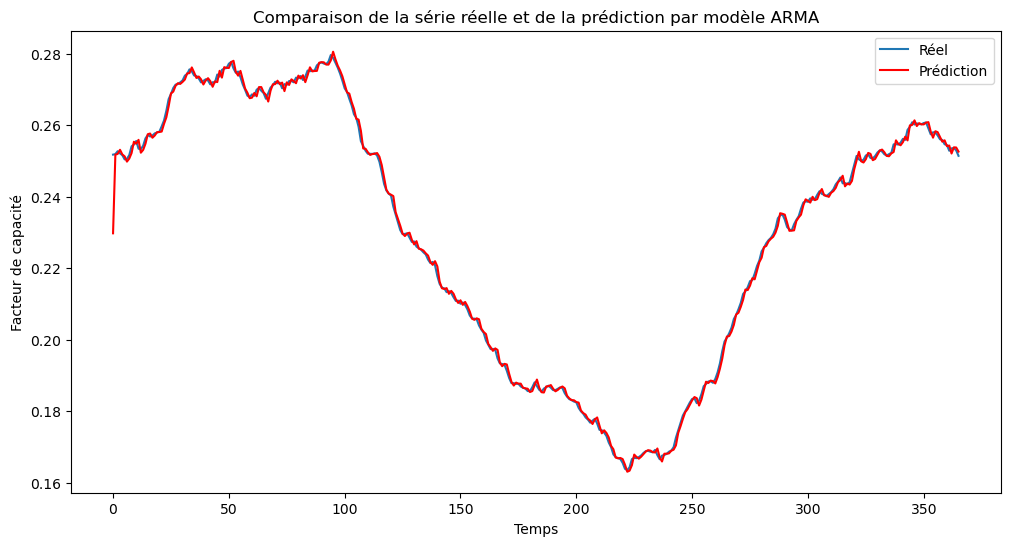

In [14]:
pred = arma.predict()

plt.figure(figsize=(12,6))
plt.plot(serie,label="Réel")
plt.plot(pred, color = "r",label="Prédiction")
plt.xlabel('Temps')
plt.ylabel('Facteur de capacité')
plt.title("Comparaison de la série réelle et de la prédiction par modèle ARMA")
plt.legend()
plt.show()

On a ainsi en rouge notre modèle et en bleu les valeurs réelles.

### ARMA avec des meilleures données

On va maintenant essayer d'appliquer la méthode Arma sur nos données journalières, auquels on a soustrait la tendance et la saisonnalité.
Pour l'instant, on va considérer la tendance comme moyenne et la saisonnalité comme la moyenne lissée sur 28 jours.

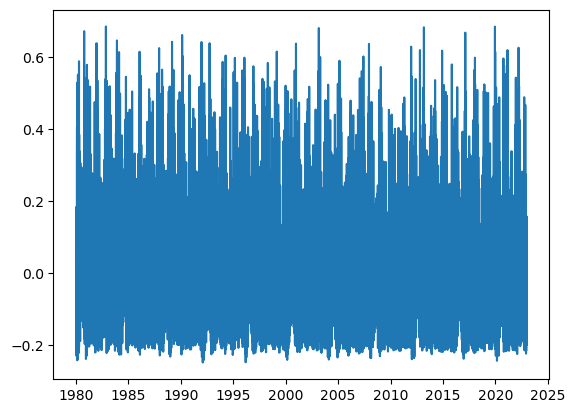

In [15]:
#Mise en forme des données

#Etant donné qu'on a pas soustrait la tendance pour calculer la saisonnalité jusqu'à maintenant, car on prend une tendance constante, je vais juste retirer la saisonnalité.


#On initialise les données
data_day_season=data_day_wind.copy()
bissextile=4

for i in range(43): #On parcourt nos 43 années de données
    
    if bissextile == 4 : #Si année bissextile
        tend=saison28
        bissextile=0
    else:
        tend=saison28[~59]
        
    #print(1980+i,int(0.75+i*365.25),int(0.75+(i+1)*365.25))
    data_day_season['electricity'][int(0.75+i*365.25):int(0.75+(i+1)*365.25)]=data_day_season['electricity'][int(0.75+i*365.25):int(0.75+(i+1)*365.25)]-tend
    
    bissextile += 1

    
plt.plot(data_day_season['electricity'])


In [16]:
serie_ = data_day_season['electricity']

_, p, _, _, _, _ = adfuller(serie_)
print("La p-value est de: ", round(p, 3))

La p-value est de:  0.0


In [31]:
result = adfuller(serie_)
print('Statistique ADF : %f' % result[0])
print('p-value : %f' % result[1])

Statistique ADF : -24.193211
p-value : 0.000000


### Etude des paramètres

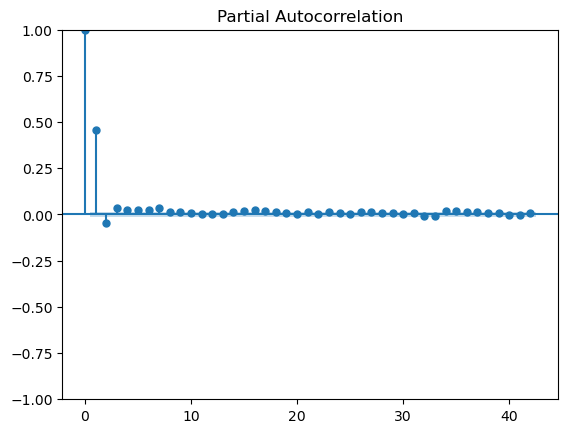

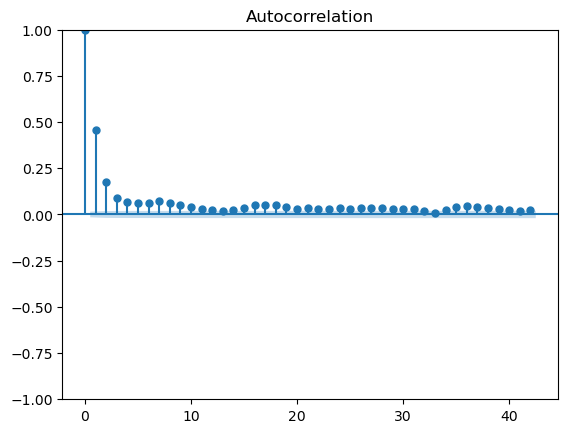

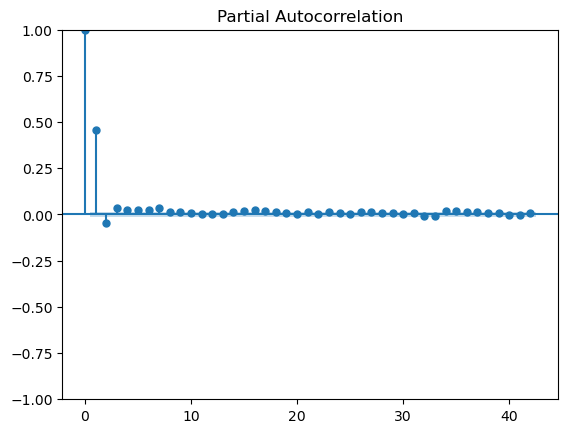

In [34]:
plot_acf(serie_)
plot_pacf(serie_)

### Modèle ARMA V1

In [43]:
# On utilise les graphes ci-dessus pour déterminer les valeurs de p et q
p = 8
q = 11
d = 0 
arma = ARIMA(serie_, order=(p,d,q)).fit()

arma.summary()

C:\Users\Manon Julia\anaconda3_2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Manon Julia\anaconda3_2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Manon Julia\anaconda3_2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Manon Julia\anaconda3_2\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            electricity   No. Observations:                15706
Model:                ARIMA(8, 0, 11)   Log Likelihood                8603.569
Date:                Sat, 09 Mar 2024   AIC                         -17165.138
Time:                        19:19:15   BIC                         -17004.240
Sample:                    01-01-1980   HQIC                        -17111.874
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0083      0.004     -2.037      0.042      -0.016      -0.000
ar.L1          0.8265      8.271      0.100      0.920     -15.384      17.037
ar.L2          0.2172     10.301      0.021      0.983     -19.971      20.406
ar.L3         -0.2150      2.323     -0.093      0.926      -4.767       4.337
ar.L4         -0.3260      2.461     -0.132      0.895      -5.149       4.497
ar.L5          0.1989      2.992      0.066      0.947      -5.665       6.063
ar.L6         -0.1158      3.914     -0.030      0.976      -7.788       7.556
ar.L7          0.2338      2.491      0.094      0.925      -4.648       5.116
ar.L8          0.1121      2.333      0.048      0.962      -4.460       4.684
ma.L1         -0.3552      8.271     -0.043      0.966     -16.566      15.855
ma.L2         -0.4486      6.450     -0.070      0.945     -13.090      12.192
ma.L3          0.0502      2.380      0.021      0.983      -4.615       4.715
ma.L4          0.3777      2.130      0.177      0.859      -3.797       4.552
ma.L5         -0.0274      3.603     -0.008      0.994      -7.089       7.034
ma.L6          0.0794      2.478      0.032      0.974      -4.778       4.937
ma.L7         -0.1643      1.202     -0.137      0.891      -2.519       2.191
ma.L8         -0.1968      1.434     -0.137      0.891      -3.007       2.613
ma.L9         -0.0795      0.872     -0.091      0.927      -1.789       1.630
ma.L10        -0.0292      0.272     -0.107      0.915      -0.563       0.504
ma.L11        -0.0087      0.123     -0.071      0.944      -0.249       0.232
sigma2         0.0196      0.000     91.610      0.000       0.019       0.020
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2749.01
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.89
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

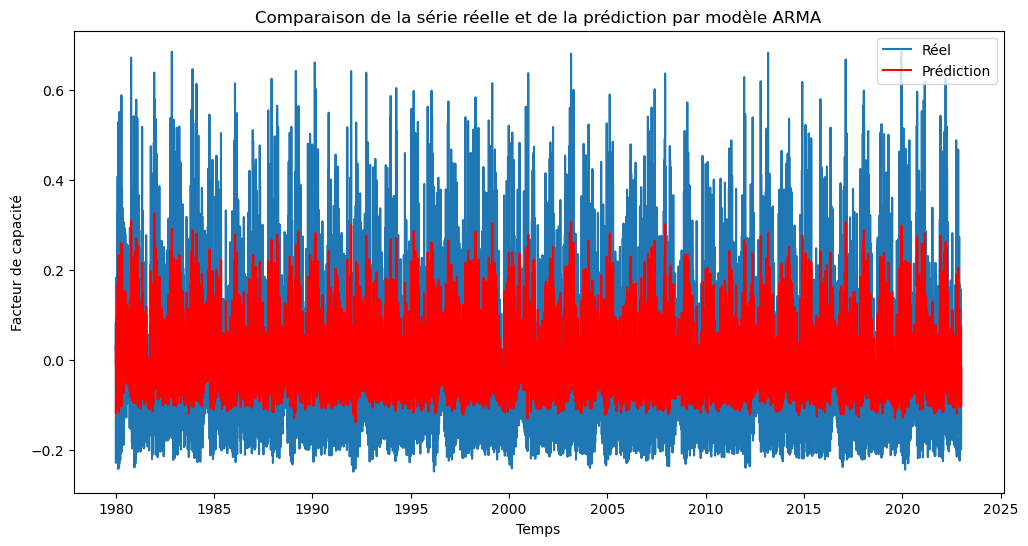

In [44]:
pred = arma.predict()

plt.figure(figsize=(12,6))
plt.plot(serie_,label="Réel")
plt.plot(pred, color = "r",label="Prédiction")
plt.xlabel('Temps')
plt.ylabel('Facteur de capacité')
plt.title("Comparaison de la série réelle et de la prédiction par modèle ARMA")
plt.legend()
plt.show()


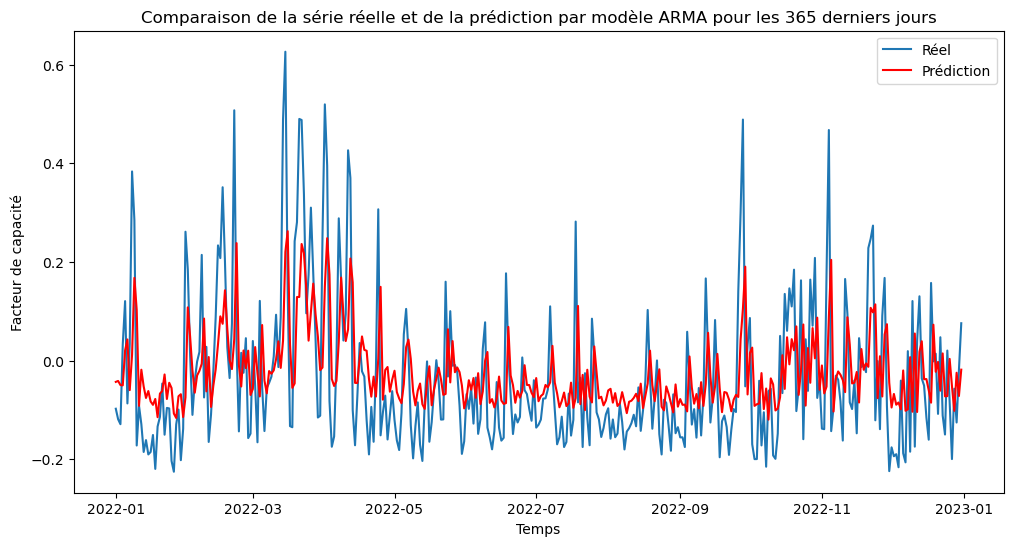

In [45]:
# Sélection des 365 derniers jours pour chaque série
serie_derniere_annee = serie_[-365:]
pred_derniere_annee = pred[-365:]

# Création du graphique
plt.figure(figsize=(12,6))

# Affichage de la série réelle pour les 365 derniers jours
plt.plot(serie_derniere_annee, label="Réel")

# Affichage de la prédiction pour les 365 derniers jours
plt.plot(pred_derniere_annee, color = "r", label="Prédiction")

# Ajout des légendes et titres
plt.xlabel('Temps')
plt.ylabel('Facteur de capacité')
plt.title("Comparaison de la série réelle et de la prédiction par modèle ARMA pour les 365 derniers jours")
plt.legend()

# Affichage du graphique
plt.show()

In [46]:
# Calcul du MSE
mse = mean_squared_error(serie_derniere_annee, pred_derniere_annee)

# Calcul du MAE
mae = mean_absolute_error(serie_derniere_annee, pred_derniere_annee)

# Calcul du RMSE
rmse = np.sqrt(mse)

# Calcul du R^2
r2 = r2_score(serie_derniere_annee, pred_derniere_annee)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MSE: 0.017252496628122435
MAE: 0.10162093340316869
RMSE: 0.13134875952258718
R²: 0.2658920366016564


### Modèle ARMA V2

In [40]:
arma = ARIMA(serie_, order=(1,0,3)).fit()

arma.summary()

C:\Users\Manon Julia\anaconda3_2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Manon Julia\anaconda3_2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Manon Julia\anaconda3_2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            electricity   No. Observations:                15706
Model:                 ARIMA(1, 0, 3)   Log Likelihood                8587.351
Date:                Sat, 09 Mar 2024   AIC                         -17162.701
Time:                        19:14:57   BIC                         -17116.730
Sample:                    01-01-1980   HQIC                        -17147.483
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0083      0.004     -2.094      0.036      -0.016      -0.001
ar.L1          0.9646      0.007    132.194      0.000       0.950       0.979
ma.L1         -0.4949      0.010    -48.381      0.000      -0.515      -0.475
ma.L2         -0.3050      0.009    -35.629      0.000      -0.322      -0.288
ma.L3         -0.1002      0.008    -12.987      0.000      -0.115      -0.085
sigma2         0.0196      0.000     91.537      0.000       0.019       0.020
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):              2772.02
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.90
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

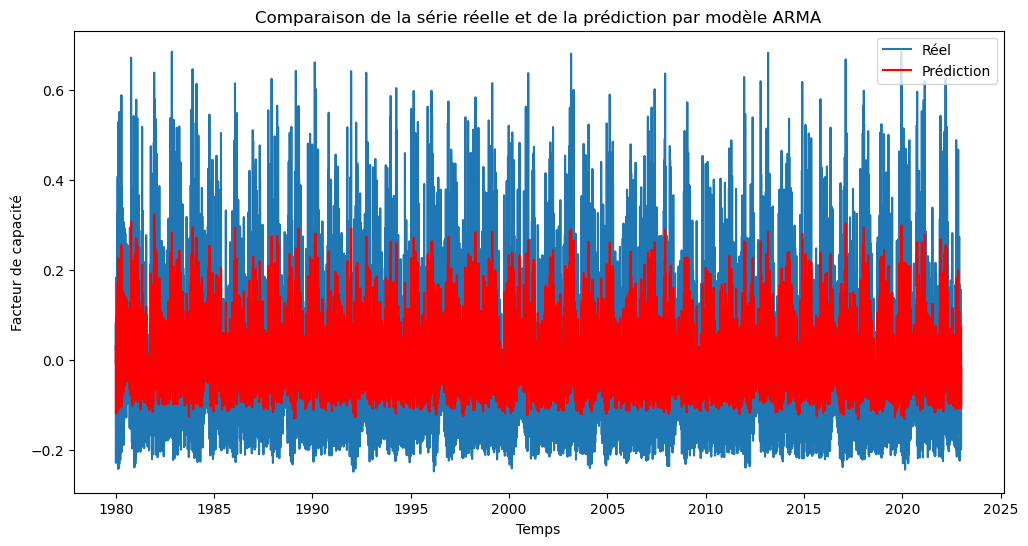

In [41]:
pred = arma.predict()

plt.figure(figsize=(12,6))
plt.plot(serie_,label="Réel")
plt.plot(pred, color = "r",label="Prédiction")
plt.xlabel('Temps')
plt.ylabel('Facteur de capacité')
plt.title("Comparaison de la série réelle et de la prédiction par modèle ARMA")
plt.legend()
plt.show()

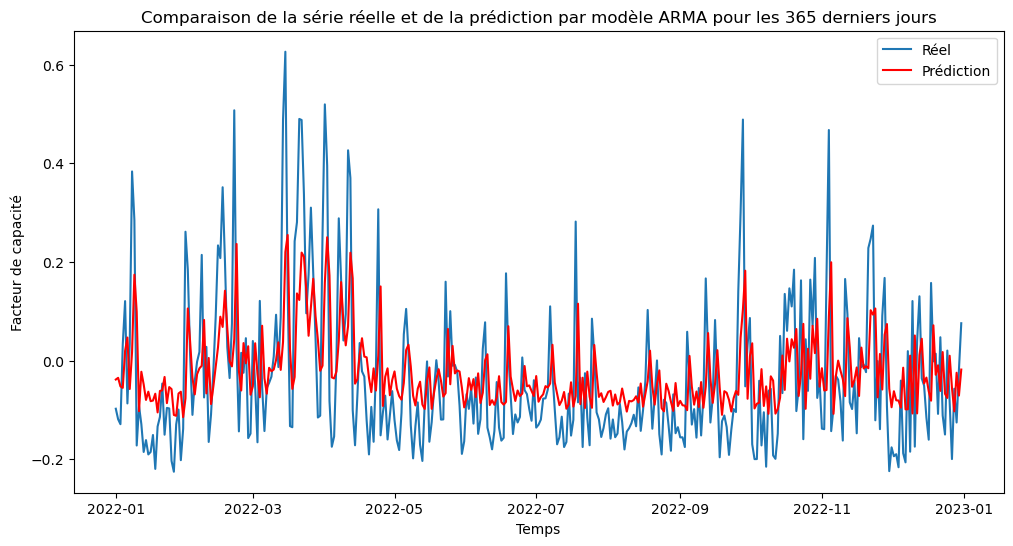

In [42]:
# Sélection des 365 derniers jours pour chaque série
serie_derniere_annee = serie_[-365:]
pred_derniere_annee = pred[-365:]

# Création du graphique
plt.figure(figsize=(12,6))

# Affichage de la série réelle pour les 365 derniers jours
plt.plot(serie_derniere_annee, label="Réel")

# Affichage de la prédiction pour les 365 derniers jours
plt.plot(pred_derniere_annee, color = "r", label="Prédiction")

# Ajout des légendes et titres
plt.xlabel('Temps')
plt.ylabel('Facteur de capacité')
plt.title("Comparaison de la série réelle et de la prédiction par modèle ARMA pour les 365 derniers jours")
plt.legend()

# Affichage du graphique
plt.show()


### Evaluation de la performance du modèle

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calcul du MSE
mse = mean_squared_error(serie_derniere_annee, pred_derniere_annee)

# Calcul du MAE
mae = mean_absolute_error(serie_derniere_annee, pred_derniere_annee)

# Calcul du RMSE
rmse = np.sqrt(mse)

# Calcul du R^2
r2 = r2_score(serie_derniere_annee, pred_derniere_annee)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MSE: 0.017183732907329927
MAE: 0.10142474656174665
RMSE: 0.13108673810622465
R²: 0.2688179896457159


* Erreur quadratique moyenne (Mean Squared Error, MSE) : elle mesure la moyenne des carrés des erreurs, c'est-à-dire, la différence moyenne entre les valeurs observées et les valeurs prédites. Plus le MSE est faible, meilleure est la prédiction.

* Erreur absolue moyenne (Mean Absolute Error, MAE) : elle mesure la moyenne des valeurs absolues des erreurs. Le MAE est plus facile à interpréter que le MSE car il est exprimé dans les mêmes unités que les données d'origine.

* Racine de l'erreur quadratique moyenne (Root Mean Squared Error, RMSE) : c'est la racine carrée du MSE. Le RMSE est utile car il donne une idée de la taille de l'erreur générée par le modèle de prédiction.

* Le coefficient de détermination (R²) : il mesure la qualité de l'ajustement d'un modèle linéaire. Pour des modèles non linéaires ou non paramétriques comme ARMA, R² peut ne pas être le meilleur indicateur de performance, mais il peut donner une indication de la proportion de la variance des données expliquée par le modèle.

### ARIMA

On commence par tester la stationnarité de la série. 

Le test augmenté de Dickey-Fuller (ADF) est une méthode statistique utilisée pour tester si une série temporelle est stationnaire. Plus précisément, il teste l'hypothèse nulle qu'une série temporelle possède une racine unitaire, ce qui indique une tendance ou un modèle de croissance persistant dans le temps et donc une non-stationnarité.

* Statistique de test : Une valeur plus négative signifie une preuve plus forte contre l'hypothèse nulle. Si la statistique de test est plus négative que la valeur critique pour un niveau de signification donné (par exemple, 1%, 5%, 10%), alors l'hypothèse nulle de la présence d'une racine unitaire est rejetée, indiquant que la série est stationnaire.

* Valeur-p : Elle indique la probabilité d'obtenir une statistique de test aussi extrême que celle observée sous l'hypothèse nulle. Une valeur-p faible (par exemple, < 0,05) conduit à rejeter l'hypothèse nulle, suggérant ainsi que la série est stationnaire.

In [21]:
# Etude de la stationnarité avec le Test Augmenté de Dickey-Fuller (ADF)
# Test ADF
result = adfuller(serie_)
print('Statistique ADF : %f' % result[0])
print('p-value : %f' % result[1])
print('Valeurs Critiques :')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interprétation
if result[1] > 0.05:
    print("La série n'est pas stationnaire.")
else:
    print("La série est stationnaire.")


Statistique ADF : -24.193211
p-value : 0.000000
Valeurs Critiques :
	1%: -3.431
	5%: -2.862
	10%: -2.567
La série est stationnaire.


La série estd déjà stationnaire d'après l'argument du test ACF. Pas besoin de la différencier, d=0.

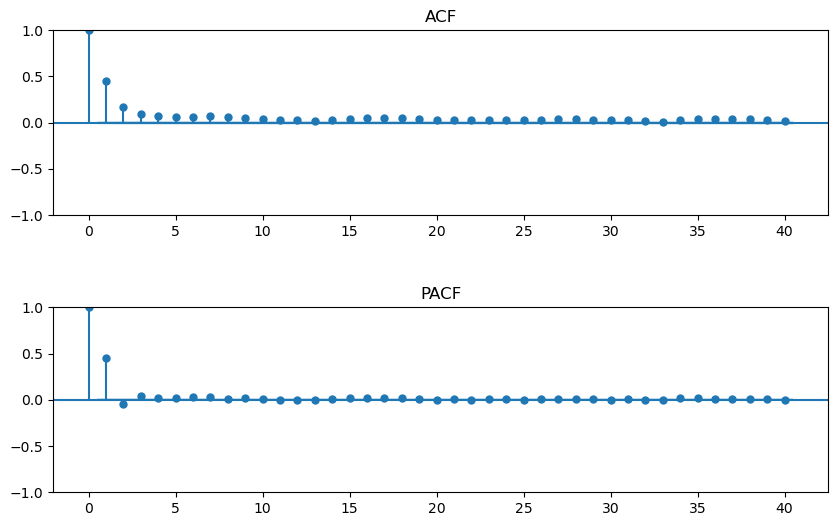

In [22]:
# Assurez-vous que 'serie_' est votre série temporelle
plt.figure(figsize=(10, 6))

# Premier graphique (ACF) en haut
plt.subplot(2, 1, 1) # 2 lignes, 1 colonne, position 1
plot_acf(serie_, ax=plt.gca(), lags=40)
plt.title('ACF')

# Deuxième graphique (PACF) en bas
plt.subplot(2, 1, 2) # 2 lignes, 1 colonne, position 2
plot_pacf(serie_, ax=plt.gca(), lags=40)
plt.title('PACF')

# Ajustement de l'espace entre les graphiques
plt.subplots_adjust(hspace=0.5) # 'hspace' contrôle l'espace vertical entre les sous-graphiques

plt.show()



Pour chaque graphe, on compte le nombre de lags avant que les autocorrélations (partielles) ne deviennent insignifiantes. Les lags sur le graphe des autocorrélations partielles permettent de déterminer p, et ceux sur le graphe des autocorrélations permettent de déterminer q. Ici, on pourrait faire une première modélisation avec p=4 et q=3 et ajuster ultérieurement ces paramètres du modèle si besoin.

C:\Users\Manon Julia\anaconda3_2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Manon Julia\anaconda3_2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Manon Julia\anaconda3_2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


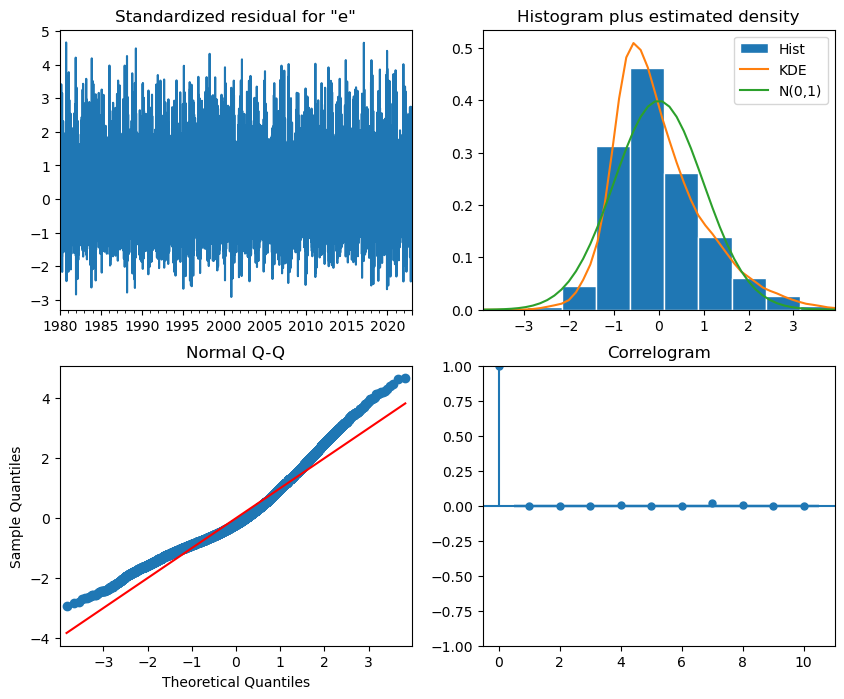

In [47]:
from statsmodels.tsa.arima.model import ARIMA

# Étape 1 : Choix des paramètres ARIMA 
p, d, q = 3, 0, 4

# Étape 2 & 3 : Vérifier la stationnarité et transformer la série si besoin 
# Déjà fait

# Étape 4 : Estimation du modèle
model = ARIMA(serie_, order=(p, d, q))
model_fit = model.fit()

# Étape 5 : Diagnostic 
model_fit.plot_diagnostics(figsize=(10,8))
plt.show()




Interprétation : 

* Résidus standardisés : Ils ne montrent pas de tendance évidente ou de saisonnalité, ce qui est positif. Cependant, des variations dans la volatilité des résidus pourraient indiquer une hétéroscédasticité.

* Q-Q Plot : La ligne droite dans la plupart des points indique que les résidus suivent approximativement une distribution normale, mais les écarts dans les extrémités suggèrent des résidus avec des queues plus lourdes que celles d'une distribution normale.

* Histogramme et densité estimée : Les résidus semblent globalement bien suivre une distribution normale, même s'il y a des déviations, en particulier aux extrémités.

* Corrélogramme : L'absence de barres dépassant les bornes de signification indique qu'il n'y a pas d'autocorrélations significatives dans les résidus, ce qui signifie que le modèle semble capturer correctement les dépendances temporelles dans les données.

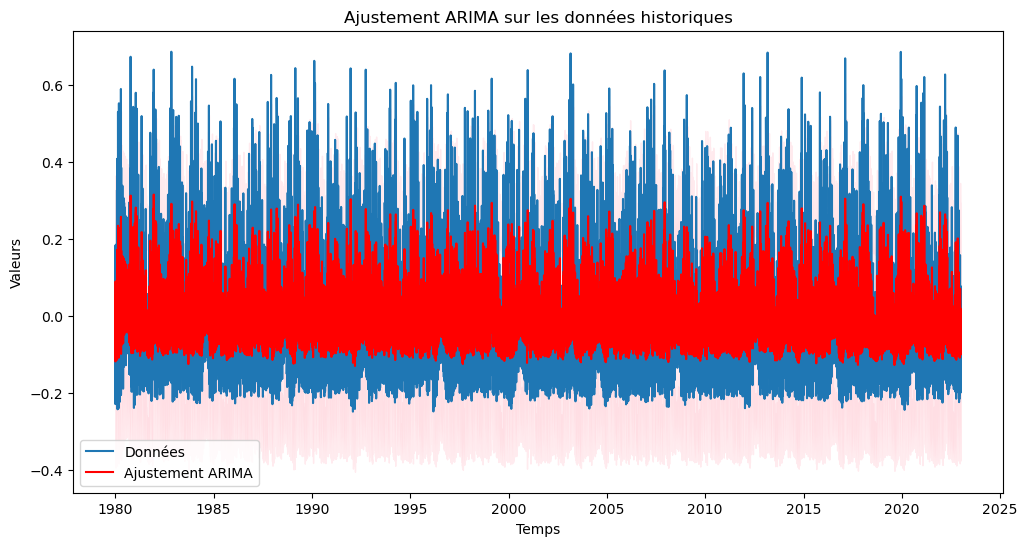

In [48]:
# Étape 6 : Ajustement du modèle aux données 
pred = model_fit.get_prediction(start=0, end=len(serie_)-1, dynamic=False)
pred_conf = pred.conf_int()

# Affichage de l'ajustement et des données historiques
plt.figure(figsize=(12,6))
plt.plot(serie_, label="Données")
plt.plot(pred.predicted_mean, label="Ajustement ARIMA", color="red")
plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Temps')
plt.ylabel('Valeurs')
plt.title('Ajustement ARIMA sur les données historiques')
plt.legend()
plt.show()


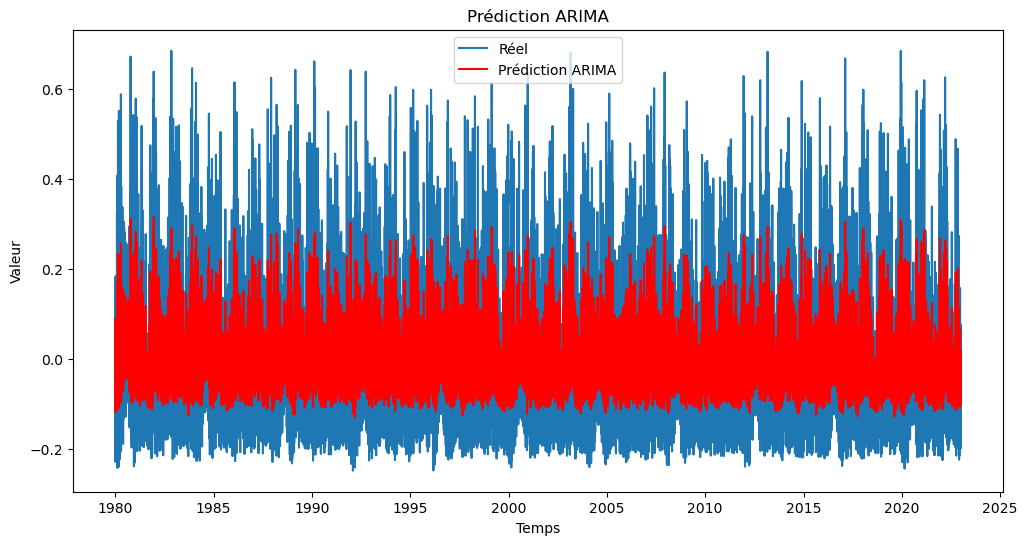

In [50]:
# Étape 6 : Prédiction 
pred = model_fit.predict(steps=len(serie_))

# Affichage de la prédiction et de la série réelle
plt.figure(figsize=(12,6))
plt.plot(serie_, label="Réel")
plt.plot(pred, color="r", label="Prédiction ARIMA")
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.title("Prédiction ARIMA")
plt.legend()
plt.show()


### SARIMA